In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.special import expit

import torch_geometric.utils
from torch_geometric.datasets import Amazon, Planetoid, WikipediaNetwork, WebKB, Actor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Core algorithms

In [2]:
def feat_filter_adaptive(feats, adj, K, reg_zero, return_coeffs=False, verbose=False):
    n, f = feats.shape

    deg = np.array(adj.sum(axis=1)).flatten()
    if 0 in deg:
        if verbose:
            print("Added self-loops where degree was 0.")
        idcs = np.argwhere(deg==0).flatten()
        vec = np.zeros(n)
        vec[idcs] = 1
        deg[idcs] = 1.
        adj_norm = sp.sparse.spdiags(deg**(-0.5),0,n,n) @ (adj+sp.sparse.spdiags(vec,0,n,n)) @ sp.sparse.spdiags(deg**(-0.5),0,n,n)
    else:
        adj_norm = sp.sparse.spdiags(deg**(-0.5),0,n,n) @ adj @ sp.sparse.spdiags(deg**(-0.5),0,n,n)
    
    feats_props = np.empty((K+1, n, f))
    feats_props[0,:,:] = feats
    
    for i in range(1,K+1):
        feats_props[i,:,:] = adj_norm @ feats_props[i-1,:,:]        
    
    coeffs = np.empty((f, K+1))
    feats_filtered = np.empty((f,n))
    
    feats_props = np.transpose(feats_props, (2,1,0)) # now it is f x n x (K+1)
    reg_vec = np.zeros(K+1); reg_vec[0] = np.sqrt(n*reg_zero)
    
    for feat_idx in range(f):
        coeffs[feat_idx,:], _, _, _ = np.linalg.lstsq(np.vstack((feats_props[feat_idx,:,:], reg_vec[None,:])),
                                                      np.append(feats_props[feat_idx,:,0], np.zeros(1)),
                                                      rcond=None)
        feats_filtered[feat_idx,:] = feats_props[feat_idx,:,:] @ coeffs[feat_idx,:]
        if verbose:
            print("Finished feat %i of %i." % (feat_idx, f))
    
    feats_filtered = feats_filtered.T # now it's n x f

    if return_coeffs:
        return feats_filtered, coeffs
    else:
        return feats_filtered
    
def feat_filter_SGC(feat, adj, K):
    n = adj.shape[0]
    adj_aug = adj + sp.sparse.eye(n)
    deg_aug = np.array(adj_aug.sum(axis=1)).flatten()
    adj_aug_norm = sp.sparse.spdiags(deg_aug**(-0.5),0,n,n) @ adj_aug @ sp.sparse.spdiags(deg_aug**(-0.5),0,n,n)
    
    feat_filter = feat
    for i in range(1,K+1):
        feat_filter = adj_aug_norm @ feat_filter
    return feat_filter

## Code to create synthetic network

In [3]:
def stochasticblock(n, communities, edge_probs, return_exp=False):
    adj_exp = np.zeros((n, n))
    num_communities = len(communities)
    for (i,j), prob in np.ndenumerate(edge_probs):
        adj_exp[np.ix_(communities[i], communities[j])] = prob
    if return_exp:
        return adj_exp
    else:
        adj = np.zeros((n, n), dtype=np.int8)
        adj[np.triu_indices(n)] = np.random.rand(n*(n+1)//2) < adj_exp[np.triu_indices(n)]
        adj = adj + adj.T
        adj[np.diag_indices(n)] = adj[np.diag_indices(n)] // 2
        return adj

In [4]:
def make_sbm_feat(n,p,q, noise_sigma=1., matshow=False):
    labels = np.zeros(n)
    labels[n//2:] = +1

    adj = stochasticblock(n, [np.arange(n//2), np.arange(n//2,n)], np.array([[p,q],[q,p]]))

    if matshow:
        matfig = plt.figure(figsize=(8,3), dpi=300)
        plt.matshow(adj, fignum=matfig.number, aspect=1)
    
    feats_true = 2.*labels - 1.
    feats = feats_true + np.random.normal(0, noise_sigma, size=n)
    
    return sp.sparse.csr_matrix(adj), feats_true, feats

## Experiments and plots for synthetic network

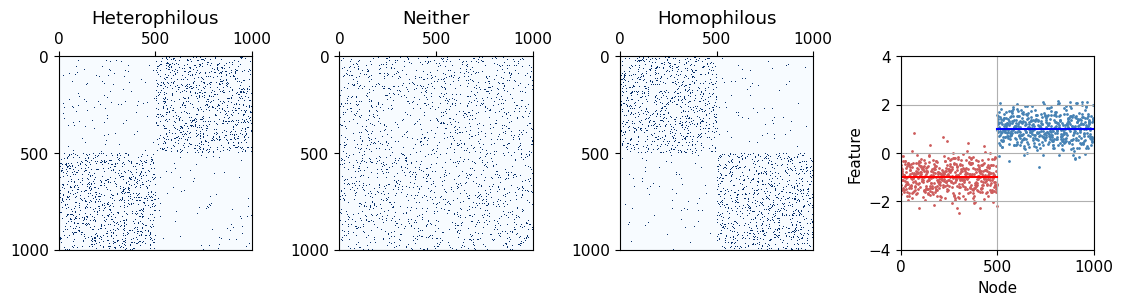

In [5]:
n = 1000
sum_exp = 10*10/n
p_q_logits = np.linspace(-2.5,2.5,3)
num_logits = len(p_q_logits)
fig, axs = plt.subplots(1,4, figsize=(17/1.5,5/1.5), dpi=100, tight_layout=True)
titles = ['Heterophilous', 'Neither', 'Homophilous']
for i, p_q_logit in enumerate(p_q_logits):
    p_frac, q_frac = expit(p_q_logit), expit(-p_q_logit)
    adj, feats_true, feats = make_sbm_feat(n=n,p=p_frac*sum_exp,q=q_frac*sum_exp, noise_sigma=0.5)
    axs[i].set_title(titles[i])
    axs[i].matshow(np.array(adj.todense()), cmap='Blues', vmin=0,vmax=1)
    axs[i].set_xticks([0,500,1000])
    axs[i].set_yticks([0,500,1000])
    axs[i].xaxis.set_ticks_position("top")

axs[3].scatter(np.arange(500),feats[:500], s=1, color='indianred')
axs[3].scatter(np.arange(500,1000),feats[500:1000], s=1, color='steelblue')
axs[3].plot([0,500], [-1,-1], color='red')
axs[3].plot([500,1000], [+1,+1], color='blue')
axs[3].grid()
axs[3].set_ylim(-4,4)
axs[3].set_xlim(0,1000)
axs[3].set_xticks([0,500,1000])
axs[3].set_xlabel("Node")
axs[3].set_ylabel("Feature")
axs[3].set_aspect(abs(1000-0)/abs(4--4))

for ax in axs:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(item.get_fontsize()*1.1)

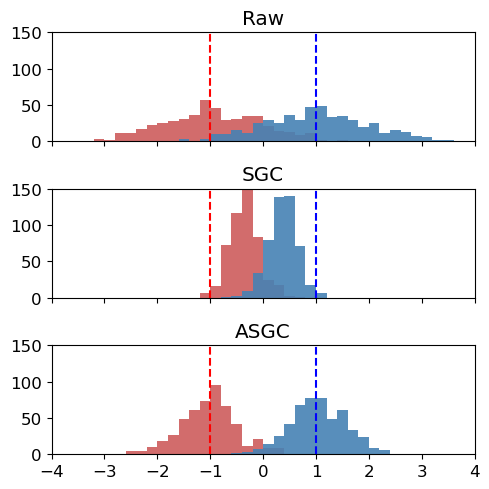

In [6]:
n = 1000

pq_sum = 10/n
lambda2 = -0.90
p, q = (pq_sum + lambda2*pq_sum) / 2., (pq_sum - lambda2*pq_sum) / 2.
adj, feats_true, feats = make_sbm_feat(n=n,p=p,q=q, noise_sigma=1.0)

deg = np.array(adj.sum(axis=1)).flatten()
deg_01 = deg.copy()
deg_01[deg==0] = 1

K=2
feats_SGC = feat_filter_SGC(feats, adj, K=K)
feats_ASGC, coeffs = feat_filter_adaptive(feats.reshape(n,1), adj, reg_zero=1e10, K=K, return_coeffs=True)
feats_ASGC = feats_ASGC.flatten()

alpha = 0.9
bins = np.linspace(-4,4,41)
fig, axs = plt.subplots(3,1, figsize=(5,5), dpi=100, tight_layout=True, sharex=True, sharey=True)
axs[0].hist(feats[:500], alpha=alpha, bins=bins, color='indianred')
axs[0].hist(feats[500:], alpha=alpha, bins=bins, color='steelblue')
axs[0].axvline(-1, color='red', linestyle='--')
axs[0].axvline(+1, color='blue', linestyle='--')
axs[0].set_title("Raw")

axs[1].hist(feats_SGC[:500], alpha=alpha, bins=bins, color='indianred')
axs[1].hist(feats_SGC[500:], alpha=alpha, bins=bins, color='steelblue')
axs[1].axvline(-1, color='red', linestyle='--')
axs[1].axvline(+1, color='blue', linestyle='--')
axs[1].set_title("SGC")

axs[2].hist(feats_ASGC[:500], alpha=alpha, bins=bins, color='indianred')
axs[2].hist(feats_ASGC[500:], alpha=alpha, bins=bins, color='steelblue')
axs[2].axvline(-1, color='red', linestyle='--')
axs[2].axvline(+1, color='blue', linestyle='--')
axs[2].set_title("ASGC")

for ax in axs:
    ax.set_xlim(-4,4)
    ax.set_ylim(0,150)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(item.get_fontsize()*1.2)

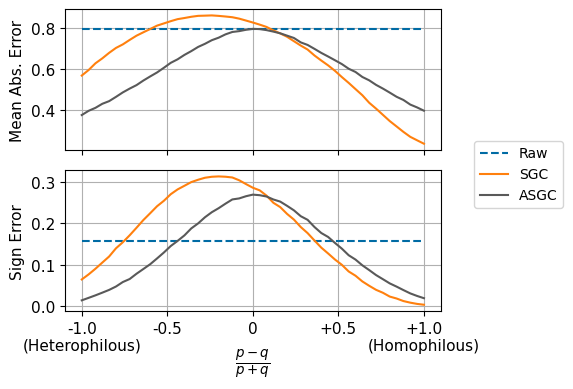

In [7]:
n = 1000
pq_sum = 10/n
lambda2_vals = np.linspace(-1,+1,51)
num_trials = 100
num_configs = len(lambda2_vals)
K = 2

SGC_mae, ASGC_mae, raw_mae = np.empty((num_configs,num_trials)), np.empty((num_configs,num_trials)), np.empty((num_configs,num_trials))
SGC_sign, ASGC_sign, raw_sign = np.empty((num_configs,num_trials)), np.empty((num_configs,num_trials)), np.empty((num_configs,num_trials))

for i, lambda2 in enumerate(lambda2_vals):
    p, q = (pq_sum + lambda2*pq_sum) / 2., (pq_sum - lambda2*pq_sum) / 2.
    for trial in range(num_trials):
        adj, feats_true, feats = make_sbm_feat(n=n,p=p,q=q, noise_sigma=1.0)
        feats_SGC = feat_filter_SGC(feats, adj, K=K)
        feats_ASGC = feat_filter_adaptive(feats.reshape(n,1), adj, K=K, reg_zero=1e10).flatten()
        SGC_mae[i,trial] = np.abs(feats_SGC - feats_true).mean()
        ASGC_mae[i,trial] = np.abs(feats_ASGC - feats_true).mean()
        raw_mae[i,trial] = np.abs(feats - feats_true).mean()
        SGC_sign[i,trial] = (np.sign(feats_SGC) == np.sign(feats_true)).mean()
        ASGC_sign[i,trial] = (np.sign(feats_ASGC) == np.sign(feats_true)).mean()
        raw_sign[i,trial] = (np.sign(feats) == np.sign(feats_true)).mean()

fig, axs = plt.subplots(2,1,figsize=(5,4),dpi=100, sharex=True, tight_layout=True)
plt.style.use('tableau-colorblind10')
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])[[0,1,3,4]]

axs[0].plot(lambda2_vals, np.ones(num_configs)*raw_mae.mean(), label='Raw', linestyle='--', color=colors[0])
axs[0].plot(lambda2_vals, SGC_mae.mean(axis=1), label='SGC', color=colors[1])
axs[0].plot(lambda2_vals, ASGC_mae.mean(axis=1), label='ASGC', color=colors[2])
axs[0].set_ylabel("Mean Abs. Error")
axs[0].grid()

axs[1].plot(lambda2_vals, 1.-np.ones(num_configs)*raw_sign.mean(), label='Raw', linestyle='--', color=colors[0])
axs[1].plot(lambda2_vals, 1.-SGC_sign.mean(axis=1), label='SGC', color=colors[1])
axs[1].plot(lambda2_vals, 1.-ASGC_sign.mean(axis=1), label='ASGC', color=colors[2])
axs[1].set_ylabel("Sign Error")
axs[1].set_xlabel(r'$\frac{p-q}{p+q}$', labelpad=-5)
axs[1].grid()
axs[1].set_xticks([-1.0,-0.5,0,+0.5,+1])
axs[1].set_xticklabels(['-1.0\n(Heterophilous)', '-0.5', '0', '+0.5', '+1.0\n(Homophilous)'])

for ax in axs:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(item.get_fontsize()*1.1)
    ax.xaxis.label.set_fontsize(ax.xaxis.label.get_fontsize()*1.25)

handles, labels = axs[1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=[1.15,0.65])
plt.tight_layout()

## Experiments on real-world data

In [8]:
def load_dataset(dataset_name):
    if dataset_name in ['computers', 'photo']:
        data = Amazon('./', dataset_name).data
    elif dataset_name in ['cora', 'citeseer', 'pubmed']:
        data = Planetoid('./', dataset_name).data
    elif dataset_name in ['chameleon', 'squirrel']:
        data = WikipediaNetwork('./', dataset_name).data
    elif dataset_name in ['film']:
        data = Actor('./', dataset_name).data
    elif dataset_name in ['cornell', 'texas']:
        data = WebKB('./', dataset_name).data
    adj = torch_geometric.utils.to_scipy_sparse_matrix(data.edge_index)
    feats = np.array(data.node_stores[0]['x'])
    labels = np.array(data.node_stores[0]['y'])
    adj = adj.maximum(adj.T)
    return adj, feats, labels

# Calculate the gap between the mean and upper bound of the 95% confidence interval:
conf_int_95 = lambda a : st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[1] - np.mean(a)

In [9]:
homoph_dsets = ['cora', 'citeseer', 'pubmed', 'computers', 'photo']
heteroph_dsets = ['chameleon', 'squirrel', 'film', 'texas', 'cornell']
all_dsets = homoph_dsets + heteroph_dsets

sgc_valid_accs, asgc_valid_accs = {}, {}
sgc_best_K_idcs, asgc_best_K_idcs, asgc_best_Rp_idcs = {}, {}, {}
raw_test_accs, sgc_test_accs, asgc_test_accs = {}, {}, {}

logreg_maxiter = 1000
num_trials = 10

K_vals = np.array([1,2,4,8]) # number of hops
Rp_vals = np.geomspace(1e-4,1e0,num=5) # zero coefficient regularization

random_states = 42*np.arange(num_trials)

for dset in all_dsets:    
    adj, feats, labels = load_dataset(dset)

    n = adj.shape[0]
    num_features, num_labels = feats.shape[1], len(set(labels))
    print("Dataset '%s' loaded. There are %i nodes, %i edges, %i features, and %i labels." % (dset, n, (adj[np.triu_indices(n)] > 0).sum(), num_features, num_labels))
    test_prop, valid_prop = (0.95, 1/2) if dset in homoph_dsets else (1/5, 1/4)

    def get_acc_with_feats(filtered_feats, random_state, valid=False):
        nontest_idcs, test_idcs = train_test_split(np.arange(n), test_size=test_prop, random_state=random_state)
        if valid:
            train_idcs, valid_idcs = train_test_split(nontest_idcs, test_size=valid_prop, random_state=random_state)
            clf = LogisticRegression(max_iter=logreg_maxiter).fit(filtered_feats[train_idcs,:], labels[train_idcs])
            return (labels[valid_idcs] == clf.predict(filtered_feats[valid_idcs,:])).mean()
        else:
            clf = LogisticRegression(max_iter=logreg_maxiter).fit(filtered_feats[nontest_idcs,:], labels[nontest_idcs])
            return (labels[test_idcs] == clf.predict(filtered_feats[test_idcs,:])).mean()
        
    raw_test_accs[dset] = np.empty((num_trials))
    for i, random_state in enumerate(random_states):
        raw_test_accs[dset][i] = get_acc_with_feats(feats, random_states[i], valid=False)
    print("\tTest accuracy with raw is %0.2f +/- %0.2f" % (100*raw_test_accs[dset].mean(), 100*conf_int_95(raw_test_accs[dset])))

    sgc_valid_accs[dset] = np.empty((num_trials, len(K_vals)))
    sgc_best_K_idcs[dset] = np.empty((num_trials), dtype=int)
    sgc_test_accs[dset] = np.empty((num_trials))
    for i, random_state in enumerate(random_states):
        for K_num, K_val in enumerate(K_vals):
            feats_filtered_sgc = feat_filter_SGC(feats, adj, K=K_val)
            sgc_valid_accs[dset][i,K_num] = get_acc_with_feats(feats_filtered_sgc, random_states[i], valid=True)
        sgc_best_K_idcs[dset][i] = sgc_valid_accs[dset][i].argmax()
        feats_filtered_sgc = feat_filter_SGC(feats, adj, K=K_vals[sgc_best_K_idcs[dset][i]])
        sgc_test_accs[dset][i] = get_acc_with_feats(feats_filtered_sgc, random_states[i])
    print("\tTest accuracy with SGC is %0.2f +/- %0.2f" % (100*sgc_test_accs[dset].mean(), 100*conf_int_95(sgc_test_accs[dset])))

    asgc_valid_accs[dset] = np.empty((num_trials, len(K_vals), len(Rp_vals)))
    asgc_best_K_idcs[dset] = np.empty((num_trials), dtype=int)
    asgc_best_Rp_idcs[dset] = np.empty((num_trials), dtype=int)
    asgc_test_accs[dset] = np.empty((num_trials))
    for i, random_state in enumerate(random_states):
        for K_num, K_val in enumerate(K_vals):
            for Rp_num, Rp_val in enumerate(Rp_vals):
                feats_filtered_asgc = feat_filter_adaptive(feats, adj, K=K_val, reg_zero=Rp_val)
                asgc_valid_accs[dset][i,K_num,Rp_num] = get_acc_with_feats(feats_filtered_asgc, random_states[i], valid=True)
        asgc_best_K_idcs[dset][i], asgc_best_Rp_idcs[dset][i] = np.unravel_index(asgc_valid_accs[dset][i].argmax(), (len(K_vals), len(Rp_vals)))
        feats_filtered_asgc = feat_filter_adaptive(feats, adj, K=K_vals[asgc_best_K_idcs[dset][i]], reg_zero=Rp_vals[asgc_best_Rp_idcs[dset][i]])
        asgc_test_accs[dset][i] = get_acc_with_feats(feats_filtered_asgc, random_states[i])
    print("\tTest accuracy with ASGC is %0.2f +/- %0.2f" % (100*asgc_test_accs[dset].mean(), 100*conf_int_95(asgc_test_accs[dset])))
    
    print()

Dataset 'cora' loaded. There are 2708 nodes, 5278 edges, 1433 features, and 7 labels.
	Test accuracy with raw is 56.36 +/- 1.57
	Test accuracy with SGC is 77.52 +/- 1.61
	Test accuracy with ASGC is 74.94 +/- 1.38

Dataset 'citeseer' loaded. There are 3327 nodes, 4552 edges, 3703 features, and 6 labels.
	Test accuracy with raw is 60.40 +/- 1.10
	Test accuracy with SGC is 70.02 +/- 1.14
	Test accuracy with ASGC is 66.86 +/- 0.86

Dataset 'pubmed' loaded. There are 19717 nodes, 44324 edges, 500 features, and 3 labels.
	Test accuracy with raw is 77.35 +/- 0.91
	Test accuracy with SGC is 73.65 +/- 1.71
	Test accuracy with ASGC is 78.72 +/- 0.88

Dataset 'computers' loaded. There are 13752 nodes, 245861 edges, 767 features, and 10 labels.
	Test accuracy with raw is 76.38 +/- 0.54
	Test accuracy with SGC is 87.32 +/- 0.34
	Test accuracy with ASGC is 87.19 +/- 0.31

Dataset 'photo' loaded. There are 7650 nodes, 119081 edges, 745 features, and 8 labels.
	Test accuracy with raw is 82.96 +/- 1.01